In [381]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [382]:
import warnings
warnings.filterwarnings('ignore')

In [383]:
"""
Contributions from:
DSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) 
https://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493
JdPaletto - Surprised Yet? - Part2 - (LB: 0.503)
https://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503
hklee - weighted mean comparisons, LB 0.497, 1ST
https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st

Also all comments for changes, encouragement, and forked scripts rock

Keep the Surprise Going
"""

'\nContributions from:\nDSEverything - Mean Mix - Math, Geo, Harmonic (LB 0.493) \nhttps://www.kaggle.com/dongxu027/mean-mix-math-geo-harmonic-lb-0-493\nJdPaletto - Surprised Yet? - Part2 - (LB: 0.503)\nhttps://www.kaggle.com/jdpaletto/surprised-yet-part2-lb-0-503\nhklee - weighted mean comparisons, LB 0.497, 1ST\nhttps://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st\n\nAlso all comments for changes, encouragement, and forked scripts rock\n\nKeep the Surprise Going\n'

In [384]:
import glob, re
import numpy as np
import pandas as pd
from sklearn import *
from datetime import datetime
import matplotlib.pyplot as plt
#from xgboost import XGBRegressor

In [385]:
air_reserve = pd.read_csv('air_reserve.csv')
air_visit_data = pd.read_csv('air_visit_data.csv')
air_store_info = pd.read_csv('air_store_info.csv')
hpg_reserve = pd.read_csv('hpg_reserve.csv')
hpg_store_info = pd.read_csv('hpg_store_info.csv')
date_info = pd.read_csv('date_info.csv')
store_id_relation = pd.read_csv('store_id_relation.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [386]:
def missing_values_table(df): 
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum()/len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    return mis_val_table_ren_columns 

In [387]:
pd.set_option('display.max_rows', 6)

In [388]:
date_info

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
...,...,...,...
514,2017-05-29,Monday,0
515,2017-05-30,Tuesday,0
516,2017-05-31,Wednesday,0


In [389]:
#
wkend_holidays = date_info.apply(lambda x: 
                                 (x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and 
                                 x.holiday_flg==1, axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0

#TF = (date_info.day_of_week == 'Saturday') | (date_info.day_of_week == 'Sunday')
#date_info.loc[TF, 'holiday_flg'] = 0　でも可

* この時の重みは2016/1/1 ~ 2017/5/31までの重み

In [390]:
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  
date_info

,calendar_date,day_of_week,holiday_flg,weight
0,2016-01-01,Friday,1,2.707368e-14
1,2016-01-02,Saturday,0,8.663577e-13
2,2016-01-03,Sunday,0,6.578904e-12
...,...,...,...,...
514,2017-05-29,Monday,0,9.808067e-01
515,2017-05-30,Tuesday,0,9.903662e-01
516,2017-05-31,Wednesday,0,1.000000e+00


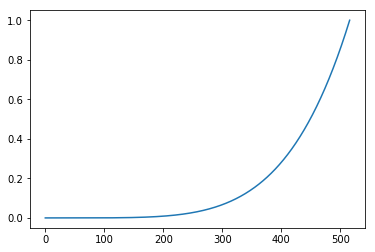

In [391]:
plt.plot(date_info.weight)

* air_store_id : 829種類 全ての日にちがあるやつもあれば直近の40日しかないものもある。
* visit_date : 2016/1/13 ~ 2017/4/22　の471日間
* visitors : 平均21人
* air_store_id, visit_date　で groupbyしてみるとmean でも　medianでも同じ数。

In [392]:
air_visit_data

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
...,...,...,...
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8
252107,air_24e8414b9b07decb,2017-04-22,5


* calendar_date : 2016/1/1 ~ 2017/5/31 の517日間
* holiday_flg　は土日をのぞいたら26日間。

In [393]:
date_info

,calendar_date,day_of_week,holiday_flg,weight
0,2016-01-01,Friday,1,2.707368e-14
1,2016-01-02,Saturday,0,8.663577e-13
2,2016-01-03,Sunday,0,6.578904e-12
...,...,...,...,...
514,2017-05-29,Monday,0,9.808067e-01
515,2017-05-30,Tuesday,0,9.903662e-01
516,2017-05-31,Wednesday,0,1.000000e+00


* air_visit_dataとdate_infoを合わせる。air_visit_dataに曜日、祝日、重みが加わった。

In [394]:
#
visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date',
                                  how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)

* 例えばこれだと、この店は計8ヶ月で、曜日ごとにこのくらい客が来ている

In [395]:
visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).sum().head(8)

visitors    weight
air_store_id         day_of_week holiday_flg                    
air_00a91d42b08b08d9 Friday      0                1460  7.559544
                     Monday      0                 765  6.388119
                                 1                  21  0.016681
...                                                ...       ...
                     Thursday    0                1135  7.507160
                     Tuesday     0                 974  7.260653
                     Wednesday   0                1125  7.436432

[8 rows x 2 columns]

* visitorsをlogとる。

In [396]:
#
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

* visit_dataの、visitorsとweightを使って重み平均算出。この2つを使って新しいvisitorsにする。

In [397]:
#
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(
    lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) 

In [398]:
visitors

,air_store_id,day_of_week,holiday_flg,visitors
0,air_00a91d42b08b08d9,Friday,0,3.583535
1,air_00a91d42b08b08d9,Monday,0,3.203625
2,air_00a91d42b08b08d9,Monday,1,3.091042
...,...,...,...,...
9100,air_fff68b929994bfbd,Tuesday,0,1.571524
9101,air_fff68b929994bfbd,Tuesday,1,0.693147
9102,air_fff68b929994bfbd,Wednesday,0,1.539125


In [399]:
#
sample_submission['air_store_id'] = sample_submission.id.map(
    lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(
    lambda x: x.split('_')[2])

* 821(個の店)×39(日分)=32019個のvisitorsを予測する。

In [400]:
sample_submission

,id,visitors,air_store_id,calendar_date
0,air_00a91d42b08b08d9_2017-04-23,0,air_00a91d42b08b08d9,2017-04-23
1,air_00a91d42b08b08d9_2017-04-24,0,air_00a91d42b08b08d9,2017-04-24
2,air_00a91d42b08b08d9_2017-04-25,0,air_00a91d42b08b08d9,2017-04-25
...,...,...,...,...
32016,air_fff68b929994bfbd_2017-05-29,0,air_fff68b929994bfbd,2017-05-29
32017,air_fff68b929994bfbd_2017-05-30,0,air_fff68b929994bfbd,2017-05-30
32018,air_fff68b929994bfbd_2017-05-31,0,air_fff68b929994bfbd,2017-05-31


* sample_submissionに曜日、祝日、重み(2017/4/23~だから変化が乏しい)を追加

In [401]:
#
sample_submission.drop('visitors', axis=1, inplace=True)

sample_submission = sample_submission.merge(
    date_info, on='calendar_date', how='left')
sample_submission

,id,air_store_id,calendar_date,day_of_week,holiday_flg,weight
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23,Sunday,0,0.682692
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24,Monday,0,0.689848
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25,Tuesday,0,0.697064
...,...,...,...,...,...,...
32016,air_fff68b929994bfbd_2017-05-29,air_fff68b929994bfbd,2017-05-29,Monday,0,0.980807
32017,air_fff68b929994bfbd_2017-05-30,air_fff68b929994bfbd,2017-05-30,Tuesday,0,0.990366
32018,air_fff68b929994bfbd_2017-05-31,air_fff68b929994bfbd,2017-05-31,Wednesday,0,1.000000


* sample_submissionに来客数を追加。この際、店ごと/曜日ごと/祝日ごと　の重み付けした来客数を追加。

In [402]:
#
sample_submission = sample_submission.merge(
    visitors, on=['air_store_id', 'day_of_week', 'holiday_flg'], how='left')
sample_submission

,id,air_store_id,calendar_date,day_of_week,holiday_flg,weight,visitors
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23,Sunday,0,0.682692,1.098612
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24,Monday,0,0.689848,3.203625
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25,Tuesday,0,0.697064,3.325868
...,...,...,...,...,...,...,...
32016,air_fff68b929994bfbd_2017-05-29,air_fff68b929994bfbd,2017-05-29,Monday,0,0.980807,1.463236
32017,air_fff68b929994bfbd_2017-05-30,air_fff68b929994bfbd,2017-05-30,Tuesday,0,0.990366,1.571524
32018,air_fff68b929994bfbd_2017-05-31,air_fff68b929994bfbd,2017-05-31,Wednesday,0,1.000000,1.539125


In [403]:
missing_values_table(sample_submission).T

,id,air_store_id,calendar_date,day_of_week,holiday_flg,weight,visitors
Missing Values,0.0,0.0,0.0,0.0,0.0,0.0,668.000000
% of Total Values,0.0,0.0,0.0,0.0,0.0,0.0,2.086261


In [404]:
#
missings = sample_submission.visitors.isnull()

* これはvisitorsの欠損値の、祝日華道家の表。

In [405]:
sample_submission[missings].holiday_flg.value_counts()

0    442
1    226
Name: holiday_flg, dtype: int64

* 以下は、air_store_id, day_of_weekだけで埋め合わせようとしているので、holiday_flgが1のものもまとめて0のもので埋め合わせようという算段。

In [406]:
#
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values
sample_submission

,id,air_store_id,calendar_date,day_of_week,holiday_flg,weight,visitors
0,air_00a91d42b08b08d9_2017-04-23,air_00a91d42b08b08d9,2017-04-23,Sunday,0,0.682692,1.098612
1,air_00a91d42b08b08d9_2017-04-24,air_00a91d42b08b08d9,2017-04-24,Monday,0,0.689848,3.203625
2,air_00a91d42b08b08d9_2017-04-25,air_00a91d42b08b08d9,2017-04-25,Tuesday,0,0.697064,3.325868
...,...,...,...,...,...,...,...
32016,air_fff68b929994bfbd_2017-05-29,air_fff68b929994bfbd,2017-05-29,Monday,0,0.980807,1.463236
32017,air_fff68b929994bfbd_2017-05-30,air_fff68b929994bfbd,2017-05-30,Tuesday,0,0.990366,1.571524
32018,air_fff68b929994bfbd_2017-05-31,air_fff68b929994bfbd,2017-05-31,Wednesday,0,1.000000,1.539125


In [407]:
#
missings = sample_submission.visitors.isnull()

In [408]:
sample_submission[missings].holiday_flg.value_counts()

0    442
1      6
Name: holiday_flg, dtype: int64

In [409]:
missing_values_table(sample_submission).T

,id,air_store_id,calendar_date,day_of_week,holiday_flg,weight,visitors
Missing Values,0.0,0.0,0.0,0.0,0.0,0.0,448.000000
% of Total Values,0.0,0.0,0.0,0.0,0.0,0.0,1.399169


* 後の欠損値は各店ごとの来客数の平均で補ってしまおうという荒いもの

In [410]:
#
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

In [411]:
missing_values_table(sample_submission).T

,id,air_store_id,calendar_date,day_of_week,holiday_flg,weight,visitors
Missing Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% of Total Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* 今まで仕上げて来たものを一旦log戻しましょう

In [412]:
#
test_visit_var = sample_submission.visitors.map(pd.np.expm1)

* 再び新しく　air_visit_data使いましょう

In [413]:
#
data = {
    'tra': pd.read_csv('air_visit_data.csv')
    }
data

{'tra':                 air_store_id  visit_date  visitors
 0       air_ba937bf13d40fb24  2016-01-13        25
 1       air_ba937bf13d40fb24  2016-01-14        32
 2       air_ba937bf13d40fb24  2016-01-15        29
 ...                      ...         ...       ...
 252105  air_24e8414b9b07decb  2017-04-20         7
 252106  air_24e8414b9b07decb  2017-04-21         8
 252107  air_24e8414b9b07decb  2017-04-22         5
 
 [252108 rows x 3 columns]}

In [414]:
#
data['tra'] = data['tra'].merge(date_info, left_on='visit_date', right_on='calendar_date', 
                                how='left')
data['tra'] = data['tra'].merge(visitors, on=['air_store_id', 'day_of_week', 'holiday_flg'], 
                                how='left')
data['tra']

,air_store_id,visit_date,visitors_x,calendar_date,day_of_week,holiday_flg,weight,visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0,1.005227e-08,2.915902
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,Thursday,0,1.456087e-08,2.739233
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,Friday,0,2.055908e-08,3.519119
...,...,...,...,...,...,...,...,...
252105,air_24e8414b9b07decb,2017-04-20,7,2017-04-20,Thursday,0,6.615795e-01,1.917453
252106,air_24e8414b9b07decb,2017-04-21,8,2017-04-21,Friday,0,6.685581e-01,1.906838
252107,air_24e8414b9b07decb,2017-04-22,5,2017-04-22,Saturday,0,6.755955e-01,1.889312


In [415]:
missing_values_table(data['tra']).T

,air_store_id,visit_date,visitors_x,calendar_date,day_of_week,holiday_flg,weight,visitors_y
Missing Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% of Total Values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [416]:
#
missings = data['tra'].visitors_y.isnull()
data['tra'].loc[missings, 'visitors_y'] = data['tra'][missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

missings = data['tra'].visitors_y.isnull()
data['tra'].loc[missings, 'visitors_y'] = data['tra'][missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

train_visit_var = data['tra'].visitors_y.map(pd.np.expm1)

In [417]:
data['tra']

,air_store_id,visit_date,visitors_x,calendar_date,day_of_week,holiday_flg,weight,visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2016-01-13,Wednesday,0,1.005227e-08,2.915902
1,air_ba937bf13d40fb24,2016-01-14,32,2016-01-14,Thursday,0,1.456087e-08,2.739233
2,air_ba937bf13d40fb24,2016-01-15,29,2016-01-15,Friday,0,2.055908e-08,3.519119
...,...,...,...,...,...,...,...,...
252105,air_24e8414b9b07decb,2017-04-20,7,2017-04-20,Thursday,0,6.615795e-01,1.917453
252106,air_24e8414b9b07decb,2017-04-21,8,2017-04-21,Friday,0,6.685581e-01,1.906838
252107,air_24e8414b9b07decb,2017-04-22,5,2017-04-22,Saturday,0,6.755955e-01,1.889312


In [418]:
#
data = {
    'tra': pd.read_csv('air_visit_data.csv'),
    'as': pd.read_csv('air_store_info.csv'),
    'hs': pd.read_csv('hpg_store_info.csv'),
    'ar': pd.read_csv('air_reserve.csv'),
    'hr': pd.read_csv('hpg_reserve.csv'),
    'id': pd.read_csv('store_id_relation.csv'),
    'tes': pd.read_csv('sample_submission.csv'),
    'hol': pd.read_csv('date_info.csv').rename(columns={'calendar_date':'visit_date'})
    }

In [419]:
#
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])

In [421]:
#
for df in ['ar','hr']:
    # 予約と実際に来た時間の差分を追加している
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime']).dt.date
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime']).dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(lambda r: (
        r['visit_datetime'] - r['reserve_datetime']).days, axis=1)

In [422]:
data['hr']

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id,reserve_datetime_diff
0,hpg_878cc70b1abc76f7,2016-01-01,2016-01-01,4,air_db80363d35f10926,0
1,hpg_878cc70b1abc76f7,2016-01-02,2016-01-02,2,air_db80363d35f10926,0
2,hpg_878cc70b1abc76f7,2016-01-03,2016-01-02,6,air_db80363d35f10926,1
...,...,...,...,...,...,...
28180,hpg_0f78ef8d1e4b23d8,2017-04-08,2017-04-03,3,air_84f6876ff7e83ae7,5
28181,hpg_0f78ef8d1e4b23d8,2017-04-08,2017-03-09,4,air_84f6876ff7e83ae7,30
28182,hpg_0f78ef8d1e4b23d8,2017-04-28,2017-04-10,5,air_84f6876ff7e83ae7,18


In [423]:
#
for df in ['ar','hr']:
    #　お店/日にちごとに分ける　→　予約と訪れる差分の時間、来客数の合計値をrs1, rv1とする
    # as_index=Falseｄは reset_index()と同じ効果
    tmp1 = data[df].groupby(['air_store_id', 'visit_datetime'], as_index=False)[
        ['reserve_datetime_diff', 'reserve_visitors']].sum().rename(
        columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs1', 
                 'reserve_visitors':'rv1'})
    tmp2 = data[df].groupby(['air_store_id', 'visit_datetime'], as_index=False)[
        ['reserve_datetime_diff', 'reserve_visitors']].mean().rename(
        columns={'visit_datetime':'visit_date', 'reserve_datetime_diff': 'rs2', 
                 'reserve_visitors':'rv2'})

In [424]:
data['hr']

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id,reserve_datetime_diff
0,hpg_878cc70b1abc76f7,2016-01-01,2016-01-01,4,air_db80363d35f10926,0
1,hpg_878cc70b1abc76f7,2016-01-02,2016-01-02,2,air_db80363d35f10926,0
2,hpg_878cc70b1abc76f7,2016-01-03,2016-01-02,6,air_db80363d35f10926,1
...,...,...,...,...,...,...
28180,hpg_0f78ef8d1e4b23d8,2017-04-08,2017-04-03,3,air_84f6876ff7e83ae7,5
28181,hpg_0f78ef8d1e4b23d8,2017-04-08,2017-03-09,4,air_84f6876ff7e83ae7,30
28182,hpg_0f78ef8d1e4b23d8,2017-04-28,2017-04-10,5,air_84f6876ff7e83ae7,18


In [425]:
#                                               
for df in ['ar','hr']:
    data[df] = pd.merge(tmp1, tmp2, how='inner', on=['air_store_id','visit_date'])

In [426]:
data['hr']

,air_store_id,visit_date,rs1,rv1,rs2,rv2
0,air_00a91d42b08b08d9,2016-01-14,3,2,3.0,2.0
1,air_00a91d42b08b08d9,2016-01-15,6,4,6.0,4.0
2,air_00a91d42b08b08d9,2016-01-16,3,2,3.0,2.0
...,...,...,...,...,...,...
18617,air_fea5dc9594450608,2017-04-25,9,2,9.0,2.0
18618,air_fea5dc9594450608,2017-04-28,29,3,29.0,3.0
18619,air_fea5dc9594450608,2017-05-20,34,6,34.0,6.0


In [427]:
data['tra']

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
...,...,...,...
252105,air_24e8414b9b07decb,2017-04-20,7
252106,air_24e8414b9b07decb,2017-04-21,8
252107,air_24e8414b9b07decb,2017-04-22,5


In [428]:
#
# air_visit_data.csv　のvisit_dateから、日にち、週、月、年全てを分解して追加
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date'])
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek
data['tra']['year'] = data['tra']['visit_date'].dt.year
data['tra']['month'] = data['tra']['visit_date'].dt.month
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date

In [429]:
data['tra']

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
...,...,...,...,...,...,...
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4
252107,air_24e8414b9b07decb,2017-04-22,5,5,2017,4


In [430]:
data['tes']

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
...,...,...
32016,air_fff68b929994bfbd_2017-05-29,0
32017,air_fff68b929994bfbd_2017-05-30,0
32018,air_fff68b929994bfbd_2017-05-31,0


In [431]:
#
# sample_submission.csv のidをバラし、時間カテゴリ名に変更、あとは日にち、週、月、年全てを分解して追加
data['tes']['visit_date'] = data['tes']['id'].map(lambda x: str(x).split('_')[2])
data['tes']['air_store_id'] = data['tes']['id'].map(lambda x: '_'.join(x.split('_')[:2]))
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date'])
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date

In [432]:
data['tes']

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
...,...,...,...,...,...,...,...
32016,air_fff68b929994bfbd_2017-05-29,0,2017-05-29,air_fff68b929994bfbd,0,2017,5
32017,air_fff68b929994bfbd_2017-05-30,0,2017-05-30,air_fff68b929994bfbd,1,2017,5
32018,air_fff68b929994bfbd_2017-05-31,0,2017-05-31,air_fff68b929994bfbd,2,2017,5


In [433]:
# 821コ
unique_stores = data['tes']['air_store_id'].unique()

In [438]:
821*7

5747

In [442]:
#
# dow : 821×7 = 5747。　つまり、821この店それぞれに[0~6]の7曜日が割り振られる感じ
# リストの中にDataFrameが7つ入っている感じ。それをconcatで縦につなぎ合わせる
stores = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)})
                    for i in range(7)], axis=0).reset_index(drop=True)
stores

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
...,...,...
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6
5746,air_fff68b929994bfbd,6


In [452]:
data['tra']

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
...,...,...,...,...,...,...
252105,air_24e8414b9b07decb,2017-04-20,7,3,2017,4
252106,air_24e8414b9b07decb,2017-04-21,8,4,2017,4
252107,air_24e8414b9b07decb,2017-04-22,5,5,2017,4


In [453]:
#
tmp = data['tra'].groupby(['air_store_id','dow']).agg(
    {'visitors' : [np.min, np.mean, np.median, np.max, np.size]}).reset_index()

tmp.columns = ['air_store_id', 'dow', 'min_visitors', 'mean_visitors', 
               'median_visitors','max_visitors','count_observations']
tmp

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1,22.457143,19.0,47,35
1,air_00a91d42b08b08d9,1,1,24.350000,24.5,43,40
2,air_00a91d42b08b08d9,2,15,28.125000,28.0,52,40
...,...,...,...,...,...,...,...
5738,air_fff68b929994bfbd,4,1,5.627907,5.0,17,43
5739,air_fff68b929994bfbd,5,2,7.439024,7.0,18,41
5740,air_fff68b929994bfbd,6,1,4.000000,3.5,10,30


In [454]:
stores

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
...,...,...
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6
5746,air_fff68b929994bfbd,6


In [459]:
#
# stores.air_store_id : 829 種類
# stores.air_store_id : 821種類
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow']) 

In [460]:
stores

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
...,...,...,...,...,...,...,...
5744,air_fef9ccb3ba0da2f7,6,2.0,10.634146,9.0,30.0,41.0
5745,air_ffcc2d5087e1b476,6,2.0,4.250000,3.5,9.0,8.0
5746,air_fff68b929994bfbd,6,1.0,4.000000,3.5,10.0,30.0


In [461]:
stores.isnull().sum()

air_store_id           0
dow                    0
min_visitors          58
                      ..
median_visitors       58
max_visitors          58
count_observations    58
Length: 7, dtype: int64

In [462]:
data['as']

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
...,...,...,...,...,...
826,air_10bbe8acd943d8f6,Asian,Tōkyō-to Shibuya-ku Shibuya,35.661777,139.704051
827,air_7514d90009613cd6,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956
828,air_c8fe396d6c46275d,Karaoke/Party,Hokkaidō Sapporo-shi Minami 3 Jōnishi,43.055460,141.340956


In [474]:
#
# data['as'].air_store_id : 829 種類
# stores.air_store_id : 821種類
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
stores

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
...,...,...,...,...,...,...,...,...,...,...,...
5744,air_fef9ccb3ba0da2f7,6,2.0,10.634146,9.0,30.0,41.0,Japanese food,Hyōgo-ken Himeji-shi Yasuda,34.815149,134.685353
5745,air_ffcc2d5087e1b476,6,2.0,4.250000,3.5,9.0,8.0,Izakaya,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
5746,air_fff68b929994bfbd,6,1.0,4.000000,3.5,10.0,30.0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288


In [ ]:
stores['air_genre_name'] = stores['air_genre_name'].map(lambda x: str(str(x).replace('/',' ')))
stores['air_area_name'] = stores['air_area_name'].map(lambda x: str(str(x).replace('-',' ')))
lbl = preprocessing.LabelEncoder()
for i in range(10):
    stores['air_genre_name'+str(i)] = lbl.fit_transform(stores['air_genre_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
    stores['air_area_name'+str(i)] = lbl.fit_transform(stores['air_area_name'].map(lambda x: str(str(x).split(' ')[i]) if len(str(x).split(' '))>i else ''))
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name'])
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])

data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week'])
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date']) 

train = pd.merge(train, stores, how='left', on=['air_store_id','dow']) 
test = pd.merge(test, stores, how='left', on=['air_store_id','dow'])

for df in ['ar','hr']:
    train = pd.merge(train, data[df], how='left', on=['air_store_id','visit_date']) 
    test = pd.merge(test, data[df], how='left', on=['air_store_id','visit_date'])

train['id'] = train.apply(lambda r: '_'.join([str(r['air_store_id']), str(r['visit_date'])]), axis=1)

train['total_reserv_sum'] = train['rv1_x'] + train['rv1_y']
train['total_reserv_mean'] = (train['rv2_x'] + train['rv2_y']) / 2
train['total_reserv_dt_diff_mean'] = (train['rs2_x'] + train['rs2_y']) / 2

test['total_reserv_sum'] = test['rv1_x'] + test['rv1_y']
test['total_reserv_mean'] = (test['rv2_x'] + test['rv2_y']) / 2
test['total_reserv_dt_diff_mean'] = (test['rs2_x'] + test['rs2_y']) / 2

# NEW FEATURES FROM JMBULL
train['date_int'] = train['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
test['date_int'] = test['visit_date'].apply(lambda x: x.strftime('%Y%m%d')).astype(int)
train['var_max_lat'] = train['latitude'].max() - train['latitude']
train['var_max_long'] = train['longitude'].max() - train['longitude']
test['var_max_lat'] = test['latitude'].max() - test['latitude']
test['var_max_long'] = test['longitude'].max() - test['longitude']

# NEW FEATURES FROM Georgii Vyshnia
train['lon_plus_lat'] = train['longitude'] + train['latitude'] 
test['lon_plus_lat'] = test['longitude'] + test['latitude']

lbl = preprocessing.LabelEncoder()
train['air_store_id2'] = lbl.fit_transform(train['air_store_id'])
test['air_store_id2'] = lbl.transform(test['air_store_id'])

train['hklee_feature'] = train_visit_var 
test['hklee_feature'] = test_visit_var

col = [c for c in train if c not in ['id', 'air_store_id', 'visit_date','visitors']]
train = train.fillna(-1)
test = test.fillna(-1)

def RMSLE(y, pred):
    return metrics.mean_squared_error(y, pred)**0.5

#Bojan Tunguz / Surprise Me 2!
model1 = ensemble.GradientBoostingRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, max_depth =10)
model2 = neighbors.KNeighborsRegressor(n_jobs=-1, n_neighbors=4)
#model3 = XGBRegressor(learning_rate=0.2, random_state=3, n_estimators=200, subsample=0.8, colsample_bytree=0.8, max_depth =10)

model1.fit(train[col], np.log1p(train['visitors'].values))
model2.fit(train[col], np.log1p(train['visitors'].values))
#model3.fit(train[col], np.log1p(train['visitors'].values))
print('RMSE GradientBoostingRegressor: ', RMSLE(np.log1p(train['visitors'].values), model1.predict(train[col])))
print('RMSE KNeighborsRegressor: ', RMSLE(np.log1p(train['visitors'].values), model2.predict(train[col])))
#print('RMSE XGBRegressor: ', RMSLE(np.log1p(train['visitors'].values), model3.predict(train[col])))
#test['visitors'] = (model1.predict(test[col]) + model2.predict(test[col]) + model3.predict(test[col])) / 3
test['visitors'] = (model1.predict(test[col]) + model2.predict(test[col])) / 2
test['visitors'] = np.expm1(test['visitors']).clip(lower=0.)
sub1 = test[['id','visitors']].copy()
del train; del data;

# from hklee
# https://www.kaggle.com/zeemeen/weighted-mean-comparisons-lb-0-497-1st/code
dfs = { re.search('/([^/\.]*)\.csv', fn).group(1):
    pd.read_csv(fn)for fn in glob.glob('../input/*.csv')}

for k, v in dfs.items(): locals()[k] = v

wkend_holidays = date_info.apply(
    (lambda x:(x.day_of_week=='Sunday' or x.day_of_week=='Saturday') and x.holiday_flg==1), axis=1)
date_info.loc[wkend_holidays, 'holiday_flg'] = 0
date_info['weight'] = ((date_info.index + 1) / len(date_info)) ** 5  

visit_data = air_visit_data.merge(date_info, left_on='visit_date', right_on='calendar_date', how='left')
visit_data.drop('calendar_date', axis=1, inplace=True)
visit_data['visitors'] = visit_data.visitors.map(pd.np.log1p)

wmean = lambda x:( (x.weight * x.visitors).sum() / x.weight.sum() )
visitors = visit_data.groupby(['air_store_id', 'day_of_week', 'holiday_flg']).apply(wmean).reset_index()
visitors.rename(columns={0:'visitors'}, inplace=True) # cumbersome, should be better ways.

sample_submission['air_store_id'] = sample_submission.id.map(lambda x: '_'.join(x.split('_')[:-1]))
sample_submission['calendar_date'] = sample_submission.id.map(lambda x: x.split('_')[2])
sample_submission.drop('visitors', axis=1, inplace=True)
sample_submission = sample_submission.merge(date_info, on='calendar_date', how='left')
sample_submission = sample_submission.merge(visitors, on=[
    'air_store_id', 'day_of_week', 'holiday_flg'], how='left')

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[visitors.holiday_flg==0], on=('air_store_id', 'day_of_week'), 
    how='left')['visitors_y'].values

missings = sample_submission.visitors.isnull()
sample_submission.loc[missings, 'visitors'] = sample_submission[missings].merge(
    visitors[['air_store_id', 'visitors']].groupby('air_store_id').mean().reset_index(), 
    on='air_store_id', how='left')['visitors_y'].values

sample_submission['visitors'] = sample_submission.visitors.map(pd.np.expm1)
sub2 = sample_submission[['id', 'visitors']].copy()
sub_merge = pd.merge(sub1, sub2, on='id', how='inner')

sub_merge['visitors'] = (sub_merge['visitors_x'] + sub_merge['visitors_y']* 1.1)/2
sub_merge[['id', 'visitors']].to_csv('submission.csv', index=False)